In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
import datetime as dt

pd.options.mode.chained_assignment = None  # default='warn'

In [124]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn import svm

## 1. Data Cleaning and Feature Engineering

#### 1.1 First clean: only take the useful columns

In [82]:
round3 = pd.read_json("round3_merged.json")
round2 = pd.read_json("round2_merged.json")
round1 = pd.read_json("round1_merged.json")

In [83]:
print round3.columns
print round2.columns
print round1.columns

Index([u'Unnamed: 0', u'account', u'actions', u'availability', u'beds',
       u'bucket_name', u'calendars', u'decision', u'discount_agreed',
       u'discount_asked', u'discount_obtained', u'extra_people',
       u'guests_included', u'host_acceptance_rate', u'host_id',
       u'host_is_superhost', u'host_name', u'host_response_rate',
       u'host_response_time', u'host_total_listings_count', u'host_url', u'id',
       u'instant_bookable', u'listing_url', u'minimum_nights',
       u'monthly_price', u'nightly_plus_guest_price', u'nightly_price',
       u'nightly_price_scraped', u'number_of_reviews', u'openings',
       u'percent_agreed', u'price_agreed', u'price_requested', u'response',
       u'room_type'],
      dtype='object')
Index([u'Unnamed: 0', u'account', u'actions', u'availability', u'beds',
       u'bucket_name', u'calendars', u'decision', u'discount_agreed',
       u'discount_asked', u'discount_obtained', u'host_acceptance_rate',
       u'host_id', u'host_is_superhost', u'ho

In [84]:
round3_clean = round3[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
round2_clean = round2[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
round1_clean = round1[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "availability", "price", "discount",
                       "calendars", "price_requested"]]

print "Number of observations in round 3: ", len(round3_clean)
print "Number of observations in round 2: ", len(round2_clean)
print "Number of observations in round 1: ", len(round1_clean)

# round3_clean.reset_index(drop=True).head()

Number of observations in round 3:  288
Number of observations in round 2:  226
Number of observations in round 1:  194


In [85]:
round1_clean = round1_clean.rename(columns = {"availability":"decision", "price":"price_agreed", "discount":"percent_agreed"})
round1_clean.head()

,id,host_id,host_response_rate,host_acceptance_rate,host_total_listings_count,instant_bookable,room_type,bucket_name,discount_asked,nightly_price,decision,price_agreed,percent_agreed,calendars,price_requested
0,5557381,28811542,100%,100%,1,t,Private room,daysM_weeks1,0.7,51,0,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",35
1,9147025,403032,100%,100%,1,f,Entire home/apt,days1_weeksM,0.7,134,-1,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",90
10,2745620,1172202,100%,100%,5,t,Private room,days3_weeks1,0.9,41,-1,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",35
100,7879486,38964485,100%,92%,2,f,Entire home/apt,days2_weeks1,0.7,101,-1,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",70
101,3557570,1594959,100%,None,1,f,Private room,daysM_weeks2,0.6,65,0,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",35


In [86]:
round1_clean = round1_clean.rename(columns = {"availability":"decision", "price":"price_agreed", "discount":"percent_agreed"})
round1_clean["percent_agreed"] = [np.nan if val==None else float(val.strip("%"))/100. for val in  round1_clean.percent_agreed.values]

combined = pd.concat([round1_clean, round2_clean, round3_clean], keys=["round1", "round2", "round3"], ignore_index=False)
combined["source"] = combined.index.labels[0]+1
combined = combined.reset_index(drop=True)

In [87]:
combined.head()

,bucket_name,calendars,decision,discount_agreed,discount_asked,host_acceptance_rate,host_id,host_response_rate,host_total_listings_count,id,instant_bookable,nightly_price,percent_agreed,price_agreed,price_requested,room_type,source
0,daysM_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",0,NaN,0.7,100%,28811542,100%,1,5557381,t,51,NaN,NaN,35,Private room,1
1,days1_weeksM,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",-1,NaN,0.7,100%,403032,100%,1,9147025,f,134,NaN,NaN,90,Entire home/apt,1
2,days3_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",-1,NaN,0.9,100%,1172202,100%,5,2745620,t,41,NaN,NaN,35,Private room,1
3,days2_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",-1,NaN,0.7,92%,38964485,100%,2,7879486,f,101,NaN,NaN,70,Entire home/apt,1
4,daysM_weeks2,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",0,NaN,0.6,None,1594959,100%,1,3557570,f,65,NaN,NaN,35,Private room,1


In [88]:
combined.isnull().sum()

bucket_name                    0
calendars                      0
decision                       0
discount_agreed              705
discount_asked                 0
host_acceptance_rate          56
host_id                        0
host_response_rate            20
host_total_listings_count      0
id                             0
instant_bookable               0
nightly_price                  0
percent_agreed               703
price_agreed                 573
price_requested              283
room_type                      0
source                         0
dtype: int64

#### 1.2 Add useful independent variables

Add variables from the calendars:
* median price
* standard deviation （normalized, using the median price)

In [89]:
calendar_price =  np.array([(np.median(calendar["price_USD"].values()), np.std(calendar["price_USD"].values()), np.max(calendar["price_USD"].values())) 
                            for calendar in combined["calendars"].values])
calendar_median_price = calendar_price[:,0]
calendar_price_std = calendar_price[:,1]
calendar_price_high = calendar_price[:,2]

combined["price_median"]=calendar_median_price
combined["price_std"]=calendar_price_std/calendar_median_price
combined["orig_percent_off"]=1-combined["nightly_price"]/calendar_price_high

* 1-month occupancy rate

In [90]:
key_1m = map(str, range(30))
calendar_occupancy = [np.mean([calendar["availability"][key] for key in key_1m]) for calendar in combined["calendars"].values]

combined["occupancy_1m"]=calendar_occupancy

Convert string variables to numeric:
* whether room will be shared
* whether instant booking is turned on
* the response rate of the host (contains nans)

In [91]:
shared = combined["room_type"].values
combined["shared"] = [x!="Entire home/apt" for x in shared]
# shared_binary

instant = combined["instant_bookable"].values
combined["instant"] = [x=="t" for x in shared]
# instant_binary

In [92]:
response_imputer = Imputer(copy=True, missing_values='NaN', strategy='mean', axis=1)
response_num = np.array([float(response_rate.strip('%'))/100 for response_rate in combined["host_response_rate"].fillna(value="-100%").values])
response_num = np.array([np.nan if x < 0 else x for x in response_num])
# response_imputer.fit(response_num)
response_imputed = response_imputer.fit_transform(response_num)[0]

# print len(response_imputed)
combined["response_rate"] = response_imputed

/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


#### 1.3 Add indicators for the buckets

Construct 11 variables: 3 types of orphans, 2 types of advances, and 3x2=6 types of interactions

In [93]:
opening_attr = combined["bucket_name"].values
# orphan = []
# advance = []
N = len(opening_attr)
orp_1 = np.zeros(N)
orp_2 = np.zeros(N)
orp_3 = np.zeros(N)
adv_1 = np.zeros(N)
adv_2 = np.zeros(N)

for (i,x) in enumerate(opening_attr):
    if x == "days1_weeks1":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days1_weeks2":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days1_weeksM":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days2_weeks1":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days2_weeks2":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days2_weeksM":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days3_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days3_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days3_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "daysM_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "daysM_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "daysM_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
        
combined["orp_1"]=orp_1
combined["orp_2"]=orp_2
combined["orp_3"]=orp_3
combined["adv_1"]=adv_1
combined["adv_2"]=adv_2

In [94]:
combined["orp_1, adv_1"] = combined["orp_1"]*combined["adv_1"]
combined["orp_1, adv_2"] = combined["orp_1"]*combined["adv_2"]
combined["orp_2, adv_1"] = combined["orp_2"]*combined["adv_1"]
combined["orp_2, adv_2"] = combined["orp_2"]*combined["adv_2"]
combined["orp_3, adv_1"] = combined["orp_3"]*combined["adv_1"]
combined["orp_3, adv_2"] = combined["orp_3"]*combined["adv_2"]

In [95]:
combined.columns

Index([              u'bucket_name',                 u'calendars',
                        u'decision',           u'discount_agreed',
                  u'discount_asked',      u'host_acceptance_rate',
                         u'host_id',        u'host_response_rate',
       u'host_total_listings_count',                        u'id',
                u'instant_bookable',             u'nightly_price',
                  u'percent_agreed',              u'price_agreed',
                 u'price_requested',                 u'room_type',
                          u'source',              u'price_median',
                       u'price_std',          u'orig_percent_off',
                    u'occupancy_1m',                    u'shared',
                         u'instant',             u'response_rate',
                           u'orp_1',                     u'orp_2',
                           u'orp_3',                     u'adv_1',
                           u'adv_2',              u'orp_1, adv

#### 1.4 Process the decision variables:

Calculate the percentage of the discount agreed:

In [96]:
combined.groupby("decision")["id"].count()/len(combined)

decision
-1    0.471751
 0    0.316384
 1    0.211864
Name: id, dtype: float64

In [97]:
orig_price = combined["nightly_price"]
price_agreed_percent = (np.nan_to_num(combined["price_agreed"])/orig_price)
discount_agreed1 = [0 if (d>=1 or d==0) else 1-d for d in price_agreed_percent]
discount_agreed2 = np.nan_to_num(combined["discount_agreed"]/orig_price)
discount_agreed3 = np.nan_to_num(combined["percent_agreed"])

discount_obtained = np.max([discount_agreed1, discount_agreed2, discount_agreed3], axis=0)
# print discount_agreed

combined["discount_obtained"] = discount_obtained

In [98]:
# print discount_agreed1, "\n"
# print discount_agreed2, "\n"
type(discount_agreed3[0])
# discount_obtained

numpy.float64

#### 1.5 Again, only keep the useful columns

In [99]:
combined.columns

Index([              u'bucket_name',                 u'calendars',
                        u'decision',           u'discount_agreed',
                  u'discount_asked',      u'host_acceptance_rate',
                         u'host_id',        u'host_response_rate',
       u'host_total_listings_count',                        u'id',
                u'instant_bookable',             u'nightly_price',
                  u'percent_agreed',              u'price_agreed',
                 u'price_requested',                 u'room_type',
                          u'source',              u'price_median',
                       u'price_std',          u'orig_percent_off',
                    u'occupancy_1m',                    u'shared',
                         u'instant',             u'response_rate',
                           u'orp_1',                     u'orp_2',
                           u'orp_3',                     u'adv_1',
                           u'adv_2',              u'orp_1, adv

In [100]:
combined_clean = combined[["host_total_listings_count", "response_rate", "instant", "shared", 
                               "price_median", "price_std", "occupancy_1m",
                               "orp_1", "orp_2", "orp_3", "adv_1", "adv_2", 
                               "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2",
                               "orig_percent_off", "discount_asked", "decision", "discount_obtained", "source"]]

In [101]:
combined_clean.head()

,host_total_listings_count,response_rate,instant,shared,price_median,price_std,occupancy_1m,orp_1,orp_2,orp_3,...,"orp_1, adv_2","orp_2, adv_1","orp_2, adv_2","orp_3, adv_1","orp_3, adv_2",orig_percent_off,discount_asked,decision,discount_obtained,source
0,1,1,False,True,45,0.090351,0.433333,0,0,0,...,0,0,0,0,0,0.055556,0.7,0,0,1
1,1,1,False,False,106,0.144629,0.700000,1,0,0,...,0,0,0,0,0,0.000000,0.7,-1,0,1
2,5,1,False,True,46,0.021650,0.366667,0,0,1,...,0,0,0,1,0,0.108696,0.9,-1,0,1
3,2,1,False,False,120,0.095207,0.500000,0,1,0,...,0,1,0,0,0,0.246269,0.7,-1,0,1
4,1,1,False,True,65,0.000000,0.933333,0,0,0,...,0,0,0,0,0,0.000000,0.6,0,0,1


## 2. Construct training samples

For studying whether hosts are negotiable, we consider 2 types of acceptance rate:

* Accepted / (Accepted + Rejected)
* Accepted / (Accepted + Rejected + No Response)

For studying how much discounts each host is willing to give, we only include hosts that gave a discount percentage.

And, for each study, the discount asked may or may not be an important factor- we will see.

In [110]:
mask_available = combined_clean["decision"] != -1 
mask_agreed = combined_clean["discount_obtained"] != 0
mask_no_source1 = combined_clean["source"] != 1

combined_available = combined_clean[mask_available]
combined_agreed = combined_clean[mask_agreed * mask_no_source1]

cal_param = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2", "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2"]
host_param = ["orig_percent_off", "host_total_listings_count", "response_rate", "instant", "shared",  "price_median", "price_std", "occupancy_1m"]
param = cal_param + host_param + ["discount_asked"]
param_noda = cal_param + host_param

X_willing = combined_available[param].values
X_willing_noda = combined_available[param_noda].values
Y_willing = combined_available["decision"].values

X_willing_all = combined_clean[param].values
X_willing_all_noda = combined_clean[param_noda].values
Y_willing_all = combined_clean["decision"].values 
Y_willing_all = np.max(zip(Y_willing_all,np.zeros(len(Y_willing_all))), axis=1)

X_discount = combined_agreed[param].values
X_discount_noda = combined_agreed[param_noda].values
Y_discount = combined_agreed["discount_obtained"].values

In [111]:
combined_agreed.head()

,host_total_listings_count,response_rate,instant,shared,price_median,price_std,occupancy_1m,orp_1,orp_2,orp_3,...,"orp_1, adv_2","orp_2, adv_1","orp_2, adv_2","orp_3, adv_1","orp_3, adv_2",orig_percent_off,discount_asked,decision,discount_obtained,source
195,1,0.90,False,False,210,0.000000,0.100000,0,0,1,...,0,0,0,1,0,0.000000,0.9,1,0.119048,2
200,1,0.92,False,True,90,0.188228,0.333333,0,0,0,...,0,0,0,0,0,0.357143,0.9,1,0.111111,2
202,1,0.76,False,False,130,0.078299,0.133333,0,0,0,...,0,0,0,0,0,0.029197,0.7,1,0.323308,2
203,1,1.00,False,False,135,0.124332,0.233333,0,0,1,...,0,0,0,0,1,0.179894,0.9,1,0.096774,2
204,3,0.90,False,True,65,0.041439,0.633333,0,0,0,...,0,0,0,0,0,0.111111,0.8,1,0.100000,2


In [112]:
print X_willing.shape
print X_willing_noda.shape
print Y_willing.shape

print X_willing_all.shape
print X_willing_all_noda.shape
print Y_willing_all.shape

print X_discount.shape
print X_discount_noda.shape
print Y_discount.shape

(374, 20)
(374, 19)
(374,)
(708, 20)
(708, 19)
(708,)
(91, 20)
(91, 19)
(91,)


In [24]:
param_label = ["1-day orphan", "2-day orphan", "3-day_orphan", "Within 1 week", "1-2 weeks in advance", 
               "1-day orphan within 1 week", "1-day orphan 1-2 weeks in advance", 
               "2-day orphan within 1 week", "2-day orphan 1-2 weeks in advance", 
               "3-day orphan within 1 week", "3-day orphan 1-2 weeks in advance", 
               "Percent off highest price", "Host listing count", "Host response rate", 
               "Instant bookable", "Space shared with host", "Usual price", "Price variation", "1-month occupancy", 
               "Discount asked"]
param_label_noda = param_label[:-1]

## 3. Model Fitting and Prediction


### 3.1 Acceptance rate as Accepted / (Accepted + Rejected)

In [25]:
def model_fitting(name, clf, X, Y, label=param_label_noda, fold=10):
    clf.fit(X,Y)
    cv_scores = -cross_val_score(clf, X, Y, scoring='mean_squared_error', cv=fold)
    print "Average Cross Validation Accuracy: \n", 1-np.mean(cv_scores)
    print "Cross Validation Accuracies by Fold: \n", 1 - np.array(cv_scores)
    
    if name=="rf":
        importances = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                     axis=0)
        indices = np.argsort(importances)[::1]
        param_label_sorted = [label[ind] for ind in indices]

        # Print the feature ranking
        # print("Feature ranking:")

        # for f in range(X.shape[1]):
            # print("%d. %s (feature %d, importance: %f)" % (f + 1, param_label[indices[f]], indices[f], importances[indices[f]]))

        # Plot the feature importances of the forest
        plt.figure(figsize=(16,10))
        plt.title("Feature Importance", fontsize=30)
        plt.barh(range(X.shape[1]), importances[indices],color="green", align="center")
        # plt.axvline(x=0.05, color="red", ls="--")
        plt.yticks(range(X.shape[1]), param_label_sorted,  fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylim([-1, X.shape[1]])
        plt.xlim([0,0.25])
        plt.grid(False)
        plt.show()
    
    if name=="lr":


#### Random Forest: Accuracy and Feature Importance

Ensemble methods: http://scikit-learn.org/stable/modules/ensemble.html
* random sample (with replacement)
* random feature
* average probablistic prediction

Average Cross Validation Accuracy: 
0.571621621622
Cross Validation Accuracies by Fold: 
[ 0.57894737  0.63157895  0.60526316  0.68421053  0.51351351  0.48648649
  0.56756757  0.54054054  0.59459459  0.51351351]


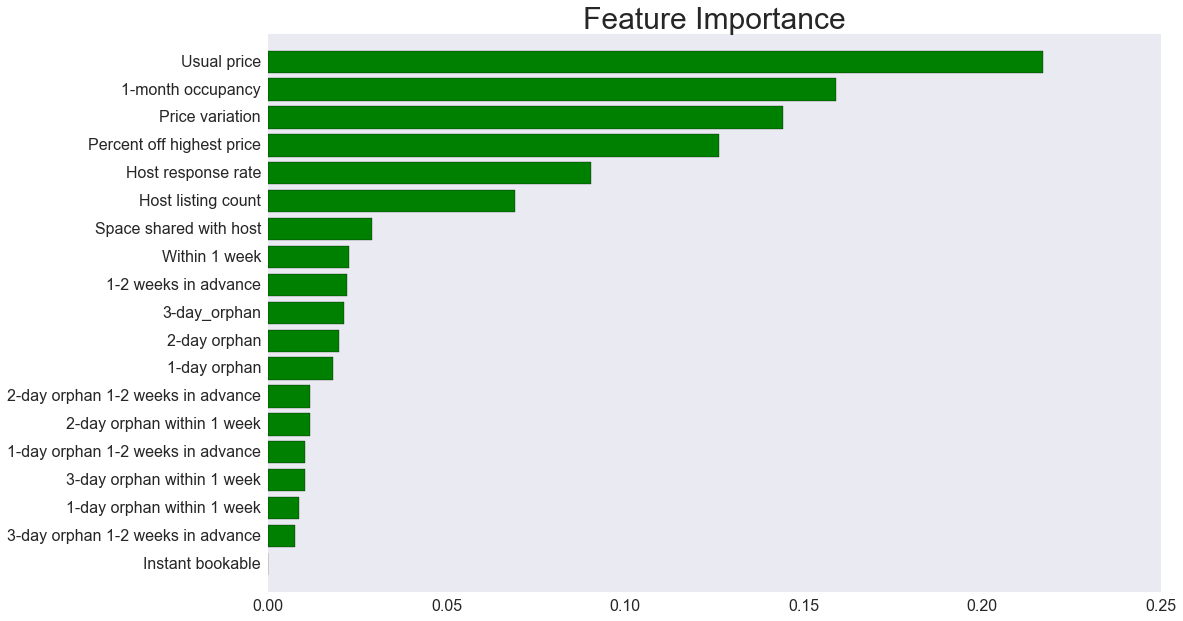

In [30]:
rf = RandomForestClassifier(n_estimators=1000, 
                            max_features=int(np.sqrt(X_willing_noda.shape[1])), 
                            max_depth=None,
                            min_samples_split=1)
model_fitting("rf", rf, X_willing_noda, Y_willing)

#### Logistic Regression: Sign of the Feature

In [27]:
lr = LogisticRegression()
model_fitting("lr", lr, X_willing_noda, Y_willing)

Average Cross Validation Accuracy: 
0.606685633001
Cross Validation Accuracies by Fold: 
[ 0.57894737  0.63157895  0.57894737  0.73684211  0.59459459  0.56756757
  0.62162162  0.56756757  0.59459459  0.59459459]
Coefficients: 



[('1-day orphan', -0.058816602782868113),
 ('2-day orphan', -0.022026427553062344),
 ('3-day_orphan', 0.40070746201403756),
 ('Within 1 week', 0.097515395250713705),
 ('1-2 weeks in advance', 0.22496053640591815),
 ('1-day orphan within 1 week', -0.34478171902228),
 ('1-day orphan 1-2 weeks in advance', 0.54910275089995431),
 ('2-day orphan within 1 week', 0.17987303899399115),
 ('2-day orphan 1-2 weeks in advance', 0.3602306873465953),
 ('3-day orphan within 1 week', -0.59735200578026548),
 ('3-day orphan 1-2 weeks in advance', -0.08199350805539328),
 ('Percent off highest price', -0.30390597775649469),
 ('Host listing count', -0.073482723858143806),
 ('Host response rate', -0.27083788268790615),
 ('Instant bookable', 0.0),
 ('Space shared with host', -0.12890504828725532),
 ('Usual price', 0.0033348535580607587),
 ('Price variation', -0.47122126194489899),
 ('1-month occupancy', -0.7555215160222245)]

#### SVM: better prediction?

In [28]:
svm = svm.SVC()
model_fitting("svm", svm, X_willing_noda, Y_willing)

Average Cross Validation Accuracy: 
0.62012802276
Cross Validation Accuracies by Fold: 
[ 0.68421053  0.57894737  0.63157895  0.65789474  0.56756757  0.59459459
  0.64864865  0.7027027   0.45945946  0.67567568]


#### Let's be crazy: 8 classifiers together

In [38]:
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(max_depth=None, n_estimators=1000, max_features=5),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

print "Average Cross Validation Accuracy:"
for name, clf in zip(names, classifiers):
    clf.fit(X_willing_noda, Y_willing)
    cv_scores = -cross_val_score(clf, X_willing_noda, Y_willing, scoring='mean_squared_error', cv=10)

    print "%s: "%name, 1-np.mean(cv_scores)

Average Cross Validation Accuracy:
Nearest Neighbors:  0.612375533428
Linear SVM:  0.596088193457
RBF SVM:  0.598790896159
Decision Tree:  0.518278805121
Random Forest:  0.582361308677
AdaBoost:  0.585419630156
Naive Bayes:  0.550568990043
Linear Discriminant Analysis:  0.606685633001
Quadratic Discriminant Analysis:  0.561166429587


/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### 3.2 Accepted / (Accepted + Rejected + No Response)

Average Cross Validation Accuracy: 
0.772595573441
Cross Validation Accuracies by Fold: 
[ 0.78873239  0.77464789  0.77464789  0.78873239  0.74647887  0.77464789
  0.77464789  0.76056338  0.8         0.74285714]


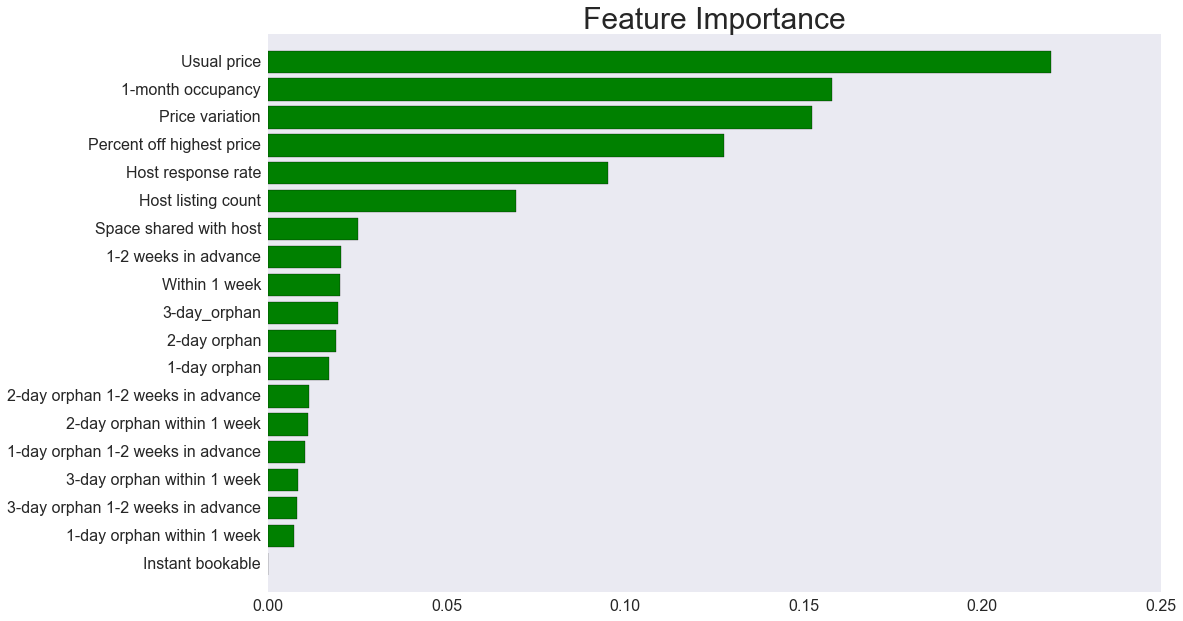

In [39]:
rf_all = RandomForestClassifier(n_estimators=1000, 
                            max_features=int(np.sqrt(X_willing_all_noda.shape[1])), 
                            max_depth=None,
                            min_samples_split=1)
model_fitting("rf", rf_all, X_willing_all_noda, Y_willing_all)

In [40]:
lr_all = LogisticRegression()
model_fitting("lr", lr_all, X_willing_all_noda, Y_willing_all)

Average Cross Validation Accuracy: 
0.786720321932
Cross Validation Accuracies by Fold: 
[ 0.78873239  0.78873239  0.78873239  0.78873239  0.78873239  0.78873239
  0.78873239  0.77464789  0.78571429  0.78571429]
Coefficients: 



[('1-day orphan', -0.18897902110224055),
 ('2-day orphan', -0.0077860875867961227),
 ('3-day_orphan', 0.19913094155695132),
 ('Within 1 week', -0.095863186501764064),
 ('1-2 weeks in advance', 0.03499736807394821),
 ('1-day orphan within 1 week', -0.51248390564400903),
 ('1-day orphan 1-2 weeks in advance', 0.52286319657636005),
 ('2-day orphan within 1 week', 0.28845645243571089),
 ('2-day orphan 1-2 weeks in advance', 0.31184602178321624),
 ('3-day orphan within 1 week', -0.45751946307823854),
 ('3-day orphan 1-2 weeks in advance', -0.36266196499991105),
 ('Percent off highest price', 0.58315524458753287),
 ('Host listing count', -0.043401677010225903),
 ('Host response rate', 0.636279795109289),
 ('Instant bookable', 0.0),
 ('Space shared with host', -0.21779510357982923),
 ('Usual price', 0.0012089199391448339),
 ('Price variation', -0.5495383823608575),
 ('1-month occupancy', -0.66698921959428403)]

In [41]:
svm_all = svm.SVC()
model_fitting("svm", svm_all, X_willing_all_noda, Y_willing_all)

Average Cross Validation Accuracy: 
0.790965794769
Cross Validation Accuracies by Fold: 
[ 0.78873239  0.8028169   0.76056338  0.78873239  0.81690141  0.78873239
  0.78873239  0.78873239  0.78571429  0.8       ]


In [43]:
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(max_depth=None, n_estimators=1000, max_features=5),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

print "Average Cross Validation Accuracy:"
for name, clf in zip(names, classifiers):
    clf.fit(X_willing_noda, Y_willing)
    cv_scores = -cross_val_score(clf, X_willing_all_noda, Y_willing_all, scoring='mean_squared_error', cv=10)

    print "%s: "%name, 1-np.mean(cv_scores)

### 3.3 Discount Obtained

Now, instead of classifiers, I used regressors for random forest, and linear regression instead of logistic.

Average Cross Validation Accuracy: 
0.988963244682
Cross Validation Accuracies by Fold: 
[ 0.99319912  0.98941842  0.99050002  0.98925472  0.98932527  0.98628544
  0.98758123  0.99152216  0.99141239  0.98113367]


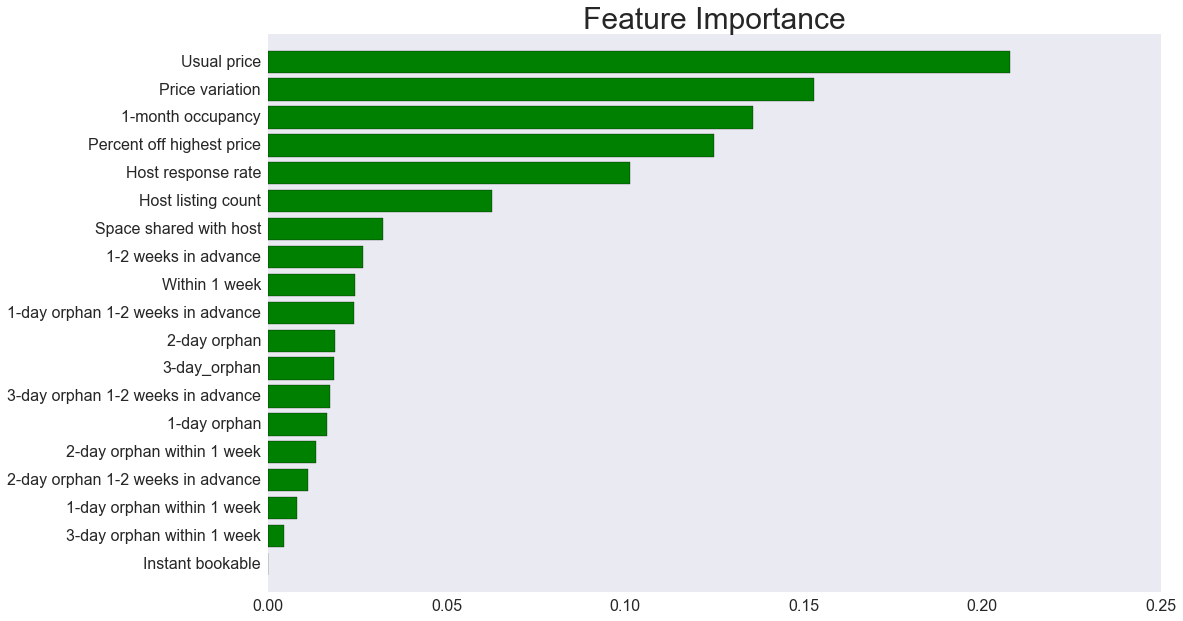

In [116]:
rf_discount = RandomForestRegressor(n_estimators=1000, 
                            max_features=int(np.sqrt(X_discount_noda.shape[1])), 
                            max_depth=None,
                            min_samples_split=1)
model_fitting("rf", rf_discount, X_discount_noda, Y_discount)

In [145]:
lr_discount = LinearRegression()
lr_discount.fit(X_discount_noda, Y_discount)

lr_discount_scores = -cross_val_score(lr_discount, X_discount_noda, Y_discount, scoring='mean_squared_error', cv=10)
print "Average Cross Validation Accuracy: \n", 1-np.mean(lr_discount_scores)
print "Cross Validation Accuracies by Fold: \n", 1 - np.array(lr_discount_scores)
print "Coefficients: \n"
zip(param_label_noda, np.ravel(lr_discount.coef_))

Average Cross Validation Accuracy: 
0.984941573391
Cross Validation Accuracies by Fold: 
[ 0.98977596  0.987797    0.97246924  0.98250821  0.99001684  0.98123999
  0.98597878  0.99017449  0.98727643  0.98217881]
Coefficients: 



[('1-day orphan', 0.061391245153123705),
 ('2-day orphan', 0.021617255355161295),
 ('3-day_orphan', 0.020906041424810975),
 ('Within 1 week', 0.092659760731504767),
 ('1-2 weeks in advance', 0.06160789750411013),
 ('1-day orphan within 1 week', -0.0094026859467369536),
 ('1-day orphan 1-2 weeks in advance', -0.022576963481932166),
 ('2-day orphan within 1 week', -0.038208171796346016),
 ('2-day orphan 1-2 weeks in advance', -0.031194525972235224),
 ('3-day orphan within 1 week', -0.071275503292604195),
 ('3-day orphan 1-2 weeks in advance', -0.019017919371763115),
 ('Percent off highest price', -0.10553109165998886),
 ('Host listing count', 0.0042370582079378355),
 ('Host response rate', -0.086287821528091058),
 ('Instant bookable', 7.8609937610866323e-17),
 ('Space shared with host', -0.025142599687997029),
 ('Usual price', 0.00015238139362796363),
 ('Price variation', 0.051101774418578126),
 ('1-month occupancy', -0.055580435742556944)]

#### Variables against discounts given

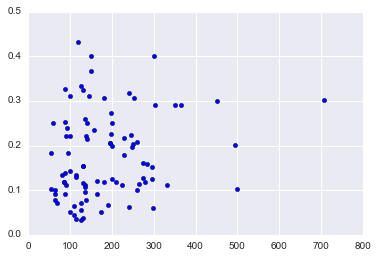

In [139]:
plt.scatter(combined_agreed["price_median"], combined_agreed["discount_obtained"])

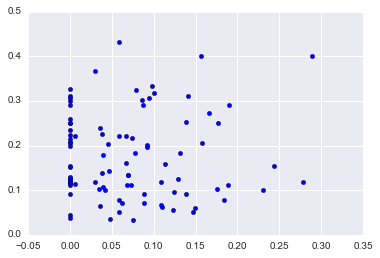

In [140]:
plt.scatter(combined_agreed["price_std"], combined_agreed["discount_obtained"])

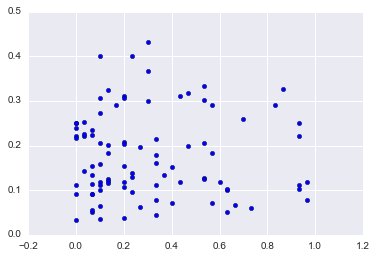

In [142]:
plt.scatter(combined_agreed["occupancy_1m"], combined_agreed["discount_obtained"])

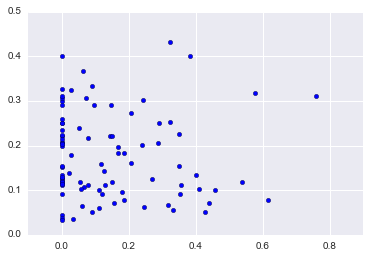

In [143]:
plt.scatter(combined_agreed["orig_percent_off"], combined_agreed["discount_obtained"])

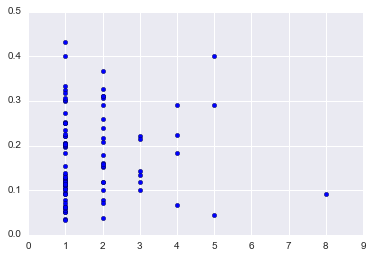

In [146]:
plt.scatter(combined_agreed["host_total_listings_count"], combined_agreed["discount_obtained"])

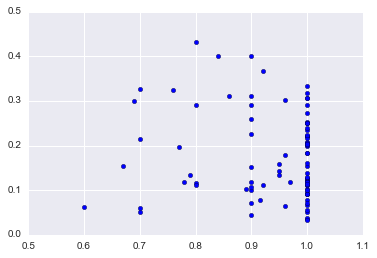

In [147]:
plt.scatter(combined_agreed["response_rate"], combined_agreed["discount_obtained"])

In [138]:
combined_agreed.head()

,host_total_listings_count,response_rate,instant,shared,price_median,price_std,occupancy_1m,orp_1,orp_2,orp_3,...,"orp_1, adv_2","orp_2, adv_1","orp_2, adv_2","orp_3, adv_1","orp_3, adv_2",orig_percent_off,discount_asked,decision,discount_obtained,source
195,1,0.90,False,False,210,0.000000,0.100000,0,0,1,...,0,0,0,1,0,0.000000,0.9,1,0.119048,2
200,1,0.92,False,True,90,0.188228,0.333333,0,0,0,...,0,0,0,0,0,0.357143,0.9,1,0.111111,2
202,1,0.76,False,False,130,0.078299,0.133333,0,0,0,...,0,0,0,0,0,0.029197,0.7,1,0.323308,2
203,1,1.00,False,False,135,0.124332,0.233333,0,0,1,...,0,0,0,0,1,0.179894,0.9,1,0.096774,2
204,3,0.90,False,True,65,0.041439,0.633333,0,0,0,...,0,0,0,0,0,0.111111,0.8,1,0.100000,2


In [ ]:
"orig_percent_off", "host_total_listings_count", "response_rate